# EDA for Boston Crime Incident Reports - 2023 to Present #

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
pd.set_option('display.max_rows', None)
import datetime
from plotly.subplots import make_subplots
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [5]:
data = pd.read_csv('Boston Data.csv', encoding='latin')
data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].str.strip()
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
data.head()

/var/folders/kv/0_31hrdn1g53jqh92jb59z080000gn/T/ipykernel_91331/1139662328.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Boston Data.csv', encoding='latin')


ï»¿_id INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0       1       232007173          3115                 NaN   
1       2       232004454          3301                 NaN   
2       3       232006290          3115                 NaN   
3       4       232024939          3114                 NaN   
4       5       232006708           423                 NaN   

    OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  SHOOTING  \
0    INVESTIGATE PERSON       B3                        0   
1        VERBAL DISPUTE       B2            316         0   
2    INVESTIGATE PERSON       A1                        0   
3  INVESTIGATE PROPERTY       B3                        0   
4  ASSAULT - AGGRAVATED       B2                        0   

           OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  UCR_PART  \
0 2023-01-27 22:44:00+00:00  2023      1      Friday    22       NaN   
1 2023-01-17 20:21:00+00:00  2023      1     Tuesday    20       NaN   
2 2023-01-24 00:00:00+00:00  2023      1     Tuesday     0       NaN   
3 2023-03-31 17:14:00+00:00  2023      3      Friday    17       NaN   
4 2023-01-26 09:00:00+00:00  2023      1    Thursday     9       NaN   

          STREET        Lat       Long  \
0       FAVRE ST  42.271661 -71.099535   
1      HAROLD ST  42.312596 -71.092876   
2     HANOVER ST  42.365699 -71.052892   
3  BLUE HILL AVE  42.292788 -71.088520   
4   HUTCHINGS ST  42.310269 -71.089311   

                                   Location  
0  (42.271661031027065, -71.09953455161765)  
1    (42.3125962960786, -71.09287583752645)  
2    (42.3656993584582, -71.05289203191269)  
3   (42.29278799134922, -71.08851953962399)  
4  (42.310268910354935, -71.08931055058088)

/var/folders/kv/0_31hrdn1g53jqh92jb59z080000gn/T/ipykernel_91331/3808370261.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Month_Year'] = data['OCCURRED_ON_DATE'].dt.to_period('M')


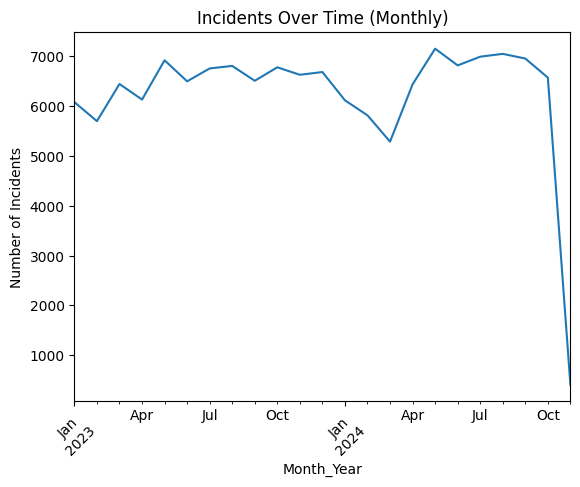

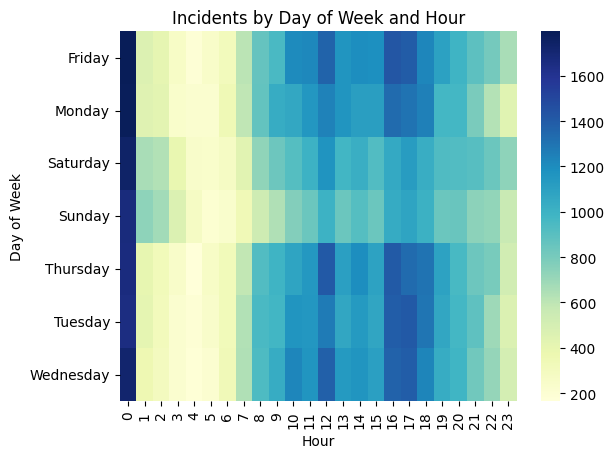

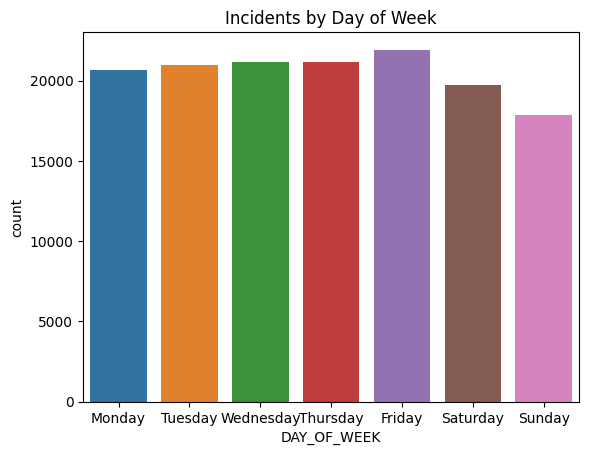

In [7]:
# Line Chart: Number of incidents over time by month
data['Month_Year'] = data['OCCURRED_ON_DATE'].dt.to_period('M')
monthly_counts = data['Month_Year'].value_counts().sort_index()
monthly_counts.plot(kind='line', title='Incidents Over Time (Monthly)', ylabel='Number of Incidents')
plt.xticks(rotation=45)
plt.show()

# Heatmap: Incidents by Day of Week and Hour
day_hour = data.groupby(['DAY_OF_WEEK', 'HOUR']).size().unstack()
sns.heatmap(day_hour, cmap='YlGnBu', annot=False)
plt.title('Incidents by Day of Week and Hour')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.show()

# Bar Chart: Incidents per Day of Week
sns.countplot(data=data, x='DAY_OF_WEEK', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Incidents by Day of Week')
plt.show()


In [15]:
Number_crimes = data['OFFENSE_DESCRIPTION'].value_counts()
values = Number_crimes.values
categories = pd.DataFrame(data=Number_crimes.index, columns=["OFFENSE_DESCRIPTION"])
categories['values'] = values
categories.head()

OFFENSE_DESCRIPTION  values
0                     INVESTIGATE PERSON   13853
1                            SICK ASSIST   12113
2  M/V - LEAVING SCENE - PROPERTY DAMAGE    8463
3                   INVESTIGATE PROPERTY    6376
4                    TOWED MOTOR VEHICLE    6227

In [16]:
def treemap(categories,title,path,values):
    fig = px.treemap(categories, path=path, values=values, height=700,
                 title=title, color_discrete_sequence = px.colors.sequential.RdBu)
    fig.data[0].textinfo = 'label+text+value'
    fig.show()

treemap(categories,'Major Crimes in Boston',['OFFENSE_DESCRIPTION'],categories['values'])

In [17]:
def histogram(data,path,color,title,xaxis,yaxis):
    fig = px.histogram(data, x=path,color=color)
    fig.update_layout(
        title_text=title,
        xaxis_title_text=xaxis, 
        yaxis_title_text=yaxis, 
        bargap=0.2, 
        bargroupgap=0.1
    )
    fig.show()

histogram(data,"OFFENSE_DESCRIPTION","OFFENSE_DESCRIPTION",'Major Crimes in Boston','Crime','Count')

In [18]:
def bar(categories,x,y,color,title,xlab,ylab):
    fig = px.bar(categories, x=x, y=y,
             color=color,
             height=400)
    fig.update_layout(
    title_text=title, 
    xaxis_title_text=xlab, 
    yaxis_title_text=ylab,
    bargap=0.2, 
    bargroupgap=0.1
    )
    fig.show()
    
bar(categories,categories['OFFENSE_DESCRIPTION'][0:10],categories['values'][0:10]
    ,categories['OFFENSE_DESCRIPTION'][0:10],'Top 10 Major Crimes in Boston','Crime','Count')

In [35]:
import re

# Center the map around the average location of all incidents
center_lat = data['Lat'].mean()
center_long = data['Long'].mean()

# Get unique types of crimes
crime_types = data['OFFENSE_DESCRIPTION'].unique()

# Create a directory to save each map if you want to save them
import os
os.makedirs("Crime_Maps", exist_ok=True)

for crime in crime_types:
    # Filter the data for the specific crime type
    crime_data = data[data['OFFENSE_DESCRIPTION'] == crime]
    
    # Create a folium map centered around the main location
    m = folium.Map(location=[center_lat, center_long], zoom_start=12, 
                   title=f"Map of {crime}")
    
    # Add a heatmap layer if there are enough points
    if len(crime_data) > 0:
        heat_data = [[row['Lat'], row['Long']] for _, row in crime_data.dropna(subset=['Lat', 'Long']).iterrows()]
        HeatMap(heat_data).add_to(m)
    
    # Sanitize the crime name for saving
    sanitized_crime = re.sub(r'[\\/:"*?<>|]+', '_', crime)  # Replace invalid characters with underscores
    
    # Save each map as an HTML file
    m.save(f"Crime_Maps/{sanitized_crime}_map.html")
    

In [37]:
# Create the main map
m = folium.Map(location=[center_lat, center_long], zoom_start=12)

# Add each crime type as a separate layer
for crime in crime_types:
    crime_data = data[data['OFFENSE_DESCRIPTION'] == crime]
    
    # Create a feature group for the specific crime
    crime_layer = folium.FeatureGroup(name=crime)
    
    # Add points to the feature group for each incident
    for _, row in crime_data.dropna(subset=['Lat', 'Long']).iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Long']],
            radius=3,
            color="red",
            fill=True,
            fill_opacity=0.6,
            popup=row['OFFENSE_DESCRIPTION']
        ).add_to(crime_layer)
    
    # Add the feature group to the map
    crime_layer.add_to(m)

# Add layer control to toggle different crime types on and off
folium.LayerControl().add_to(m)

m.save("All_Crime_Types_Map.html")


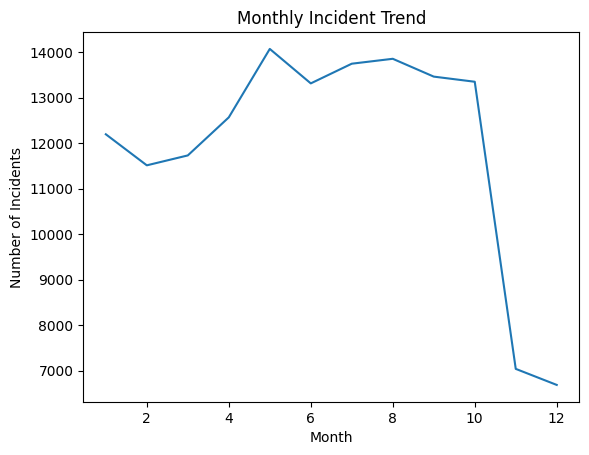

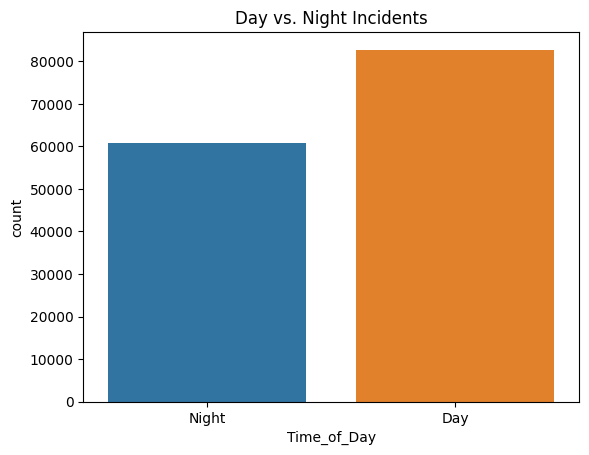

In [26]:
# Monthly Trend Line
monthly_trend = data.groupby('MONTH').size()
monthly_trend.plot(kind='line', title='Monthly Incident Trend')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

# Day and Night Analysis
data['Time_of_Day'] = data['HOUR'].apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
sns.countplot(data=data, x='Time_of_Day')
plt.title('Day vs. Night Incidents')
plt.show()


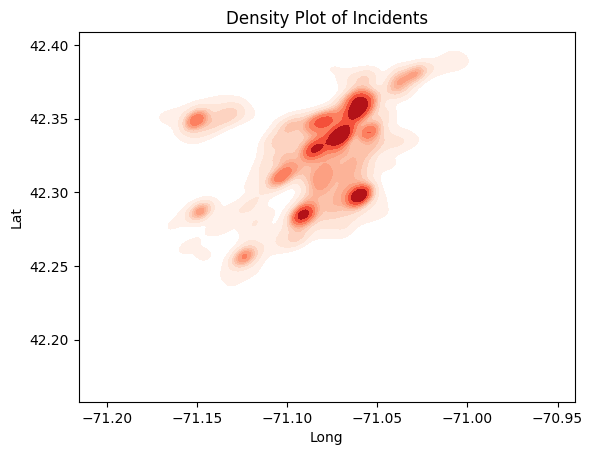

In [30]:
# Density Plot for Incident Locations
data = data.dropna(subset=['Long', 'Lat'])
sns.kdeplot(data=data, x='Long', y='Lat', fill=True, cmap="Reds", thresh=0.05)
plt.title('Density Plot of Incidents')
plt.show()

# Heatmap Overlay on Map for Density (requires lat/long density calculation)
m = folium.Map(location=[data['Lat'].mean(), data['Long'].mean()], zoom_start=12)
heat_data = [[row['Lat'], row['Long']] for _, row in data.iterrows()]
HeatMap(heat_data).add_to(m)
m.save("incident_density_map.html")
